In [1]:
import pandas as pd
import os, sys
import librosa
import opensmile
import numpy as np

### Config

In [2]:
BASE_PATH = '/scratch/elec/puhe/c/muse_2023/'
MIMIC = 'mimic'
HUMOR = 'humor'
PERSONALISATION = 'personalisation'
PATH_TO_FEATURES = {
    MIMIC: os.path.join(BASE_PATH, 'c1_muse_mimic/features'),
    HUMOR: os.path.join(BASE_PATH, 'c2_muse_humor/feature_segments'),
    PERSONALISATION: os.path.join(BASE_PATH, 'c3_muse_personalisation/feature_segments')
}
PATH_TO_LABELS = {
    MIMIC: os.path.join(BASE_PATH, 'c1_muse_mimic'),
    HUMOR: os.path.join(BASE_PATH, 'c2_muse_humor/label_segments'),
    PERSONALISATION: os.path.join(BASE_PATH, 'c3_muse_personalisation/label_segments')
}

### Audio

In [3]:
feat_type = 'w2v-msp'
speaker_id = '54_train' # '54_train'
extention = '.csv'
fname = os.path.join(PATH_TO_FEATURES[PERSONALISATION], feat_type, speaker_id+extention)
df = pd.read_csv(fname)
df.shape

(120, 1026)

### Arousal-Valence
- Continuous Emotion

<Axes: title={'center': 'physio-arousal'}>

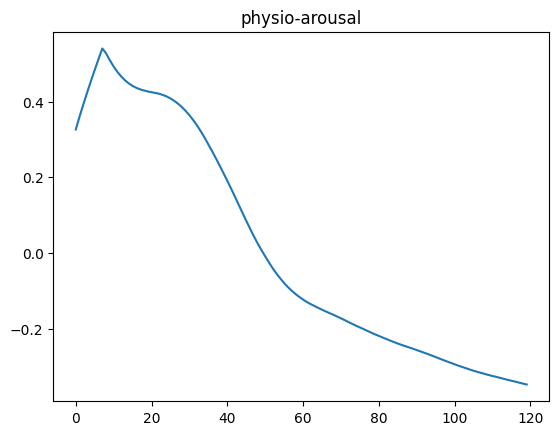

In [4]:
label_type = 'physio-arousal' # 'valence'
fname = os.path.join(PATH_TO_LABELS[PERSONALISATION], label_type, speaker_id+extention)
df = pd.read_csv(fname)
df.shape
df.head(3)
df['value'].plot(title=label_type)

### 'Smoothed' Biosignals

(120, 3)


<Axes: title={'center': 'ECG'}>

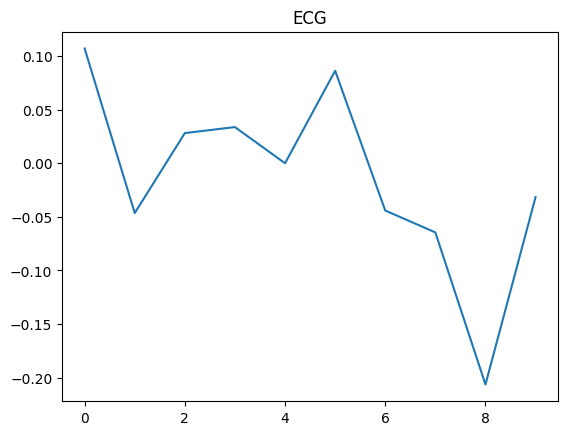

In [5]:
# filtered and smoothed 2 Hz, sampled every 500ms
feat_type= 'ECG' #  'BPM' # 'resp'
fname = os.path.join(PATH_TO_FEATURES[PERSONALISATION], feat_type, speaker_id+extention)
df = pd.read_csv(fname)
print(df.shape)
df[feat_type][:10,].plot(title=feat_type)

#### 'Raw' Biosignal
- (default) downsample 1kHz to 2Hz via filter & smoothing (MUSE)
- time series feature extraction
- learning data representations via autoencoders

(120, 3)


<Axes: >

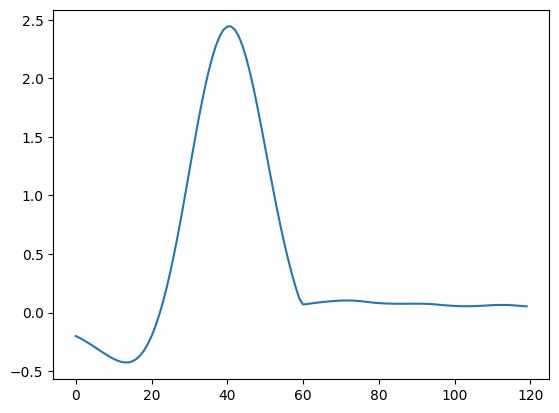

In [6]:
# input 1kHz, sampled every 1ms
fname = f'/scratch/elec/puhe/c/muse_2023/c3_muse_personalisation/raw_data/{feat_type}/{speaker_id}.csv' # 61_train
df = pd.read_csv(fname)
print(df.shape)
df[feat_type][:5000,].plot()

##### Feature Extractor

In [7]:
#from data_preprocesser import segment_ndarray

def segment_ndarray(sample:np.ndarray, win_len, hop_len):
    """
    source: https://github.com/EIHW/MuSe-2023/blob/bb5f7f2332192e5a3f603728c36385bd4a3000c7/data_parser.py
    tbd: pad_mode as in librosay mfcc 'center=True'. missing 1 step
    """
    segmented_sample = []
    if len(sample) > win_len:
        sample = np.pad(sample, (win_len//2, win_len//2), 'edge') 

    for s_idx in range(0, len(sample), hop_len):
        e_idx = min(s_idx + win_len, len(sample))
        segment = sample[s_idx:e_idx]
        segmented_sample.append(segment)
        if e_idx == len(sample):
            break

    return segmented_sample

In [8]:
# output 2Hz, sampled every 500ms
sampling_rate = 1000 # input
hop_len = 500 # output
win_len = 1000 #
feat_type = 'ECG'
fname = f'/scratch/elec/puhe/c/muse_2023/c3_muse_personalisation/raw_data/{feat_type}/61_train.csv' # 
df = pd.read_csv(fname)
data = df[feat_type].to_numpy()
df.shape, data.shape, df.head(3) # df has columns: timestamp, segment_id, features*

((120, 3),
 (120,),
    timestamp  segment_id       ECG
 0      0.000           1 -0.028992
 1      0.001           1 -0.031433
 2      0.002           1 -0.032654)

In [9]:
data = np.random.rand(12000)
samples = segment_ndarray(data, win_len, hop_len)
segment = samples[0]
len(samples), segment.shape

(25, (1000,))

In [10]:
# egemaps
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,)
_feats = []
for i, segment in enumerate(samples):
    egemaps = smile.process_signal(segment, sampling_rate)
    _feats.append(egemaps.values.squeeze())
feats = np.asarray(_feats)
feats.shape    

(25, 88)

In [11]:
# mfcc
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_fft=1024, n_mfcc=20, hop_length=hop_len)
mfccs.shape

(20, 25)

In [12]:
# mel spectrogram
melspecs = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128, hop_length=hop_len)
melspecs.shape

(128, 25)